In [13]:
!pip install datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import string

# 定义字典
char2indx = {s: i for i, s in enumerate(string.ascii_lowercase)}
char2indx

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [2]:
example = 'love'
idx = []

for i in example:
    idx.append(char2indx[i])

idx = torch.tensor(idx)
idx

tensor([11, 14, 21,  4])

In [3]:
# 使用独热编码，将文本转换为二维张量
num_claz = len(char2indx.keys())
x = F.one_hot(idx, num_classes=num_claz).float()
x, x.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([4, 26]))

In [6]:
dims = 5
num_claz = len(char2indx.keys())
x = F.one_hot(idx, num_classes=num_claz).float()
w = torch.randn(num_claz, dims)
(x @ w), (x @ w).shape

(tensor([[ 0.3965, -0.3958, -1.2064, -0.6724, -0.4768],
         [ 0.9620,  0.5876,  0.8376, -0.4350, -0.3379],
         [-2.5578, -0.0305, -0.2124, -0.5916,  0.1987],
         [-0.0834,  0.4715,  1.7552, -0.3915,  1.9801]]),
 torch.Size([4, 5]))

In [7]:
w[idx], w[idx].shape

(tensor([[ 0.3965, -0.3958, -1.2064, -0.6724, -0.4768],
         [ 0.9620,  0.5876,  0.8376, -0.4350, -0.3379],
         [-2.5578, -0.0305, -0.2124, -0.5916,  0.1987],
         [-0.0834,  0.4715,  1.7552, -0.3915,  1.9801]]),
 torch.Size([4, 5]))

In [8]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dims):
        self.weight = torch.randn((num_embeddings, embedding_dims), requires_grad=True)

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

In [9]:
em = Embedding(num_claz, 5)
x = torch.randint(0, num_claz, (10, ))
em(x).shape

torch.Size([10, 5])

In [10]:
x = torch.randint(0, num_claz, (20, 10))
em(x).shape

torch.Size([20, 10, 5])

In [11]:
torch.cuda.is_available()

True

In [12]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

torch.manual_seed(12046)

In [48]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 1000
learning_rate = 0.01
eval_iters = 10

In [15]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

Filter:   0%|          | 0/412178 [00:00<?, ? examples/s]

In [19]:
print(datasets[8]['whole_func_string'])

def to_arrow_schema(schema):
    """ Convert a schema from Spark to Arrow
    """
    import pyarrow as pa
    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)
              for field in schema]
    return pa.schema(fields)


In [20]:
print(datasets[8: 9]['whole_func_string'])

['def to_arrow_schema(schema):\n    """ Convert a schema from Spark to Arrow\n    """\n    import pyarrow as pa\n    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)\n              for field in schema]\n    return pa.schema(fields)']


In [21]:
class CharTokenizer:

    def __init__(self, data, begin_ind=0, end_ind=1):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 2 for i, s in enumerate(chars)}
        self.char2ind['<|b|>'] = begin_ind
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.begin_ind = begin_ind
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

In [24]:
tokenizer = CharTokenizer(datasets['whole_func_string'])

In [25]:
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
re

[71, 72, 73, 3, 73, 11, 91, 12, 29]

In [27]:
''.join(tokenizer.decode(re))

'def f(x):'

In [28]:
def autoregressive_trans(text, tokenizer, context_length=10):
    # text: str
    inputs, labels = [], []
    bind = tokenizer.begin_ind
    eind = tokenizer.end_ind
    enc = tokenizer.encode(text)
    # 增加特殊字符
    data = [bind] * context_length + enc + [eind]
    for i in range(len(data) - context_length):
        inputs.append(data[i: i + context_length])
        labels.append(data[i + context_length])
    return inputs, labels

In [31]:
inputs, labels = autoregressive_trans(test_str, tokenizer, 3)
for a, b in zip(inputs, labels):
    print(f'{"".join(tokenizer.decode(a))} -----> {tokenizer.decode(b)}')

<|b|><|b|><|b|> -----> d
<|b|><|b|>d -----> e
<|b|>de -----> f
def ----->  
ef  -----> f
f f -----> (
 f( -----> x
f(x -----> )
(x) -----> :
x): -----> <|e|>


In [32]:
def process(data, tokenizer):
    text = data['whole_func_string']
    # text: str
    if isinstance(text, str):
        inputs, labels = autoregressive_trans(text, tokenizer)
        return {'inputs': inputs, 'labels': labels}
    # text: list[str]
    inputs, labels = [], []
    for t in text:
        i, l = autoregressive_trans(t, tokenizer)
        inputs += i
        labels += l
    return {'inputs': inputs, 'labels': labels}

In [33]:
process(datasets[8], tokenizer)

{'inputs': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 71],
  [0, 0, 0, 0, 0, 0, 0, 0, 71, 72],
  [0, 0, 0, 0, 0, 0, 0, 71, 72, 73],
  [0, 0, 0, 0, 0, 0, 71, 72, 73, 3],
  [0, 0, 0, 0, 0, 71, 72, 73, 3, 87],
  [0, 0, 0, 0, 71, 72, 73, 3, 87, 82],
  [0, 0, 0, 71, 72, 73, 3, 87, 82, 66],
  [0, 0, 71, 72, 73, 3, 87, 82, 66, 68],
  [0, 71, 72, 73, 3, 87, 82, 66, 68, 85],
  [71, 72, 73, 3, 87, 82, 66, 68, 85, 85],
  [72, 73, 3, 87, 82, 66, 68, 85, 85, 82],
  [73, 3, 87, 82, 66, 68, 85, 85, 82, 90],
  [3, 87, 82, 66, 68, 85, 85, 82, 90, 66],
  [87, 82, 66, 68, 85, 85, 82, 90, 66, 86],
  [82, 66, 68, 85, 85, 82, 90, 66, 86, 70],
  [66, 68, 85, 85, 82, 90, 66, 86, 70, 75],
  [68, 85, 85, 82, 90, 66, 86, 70, 75, 72],
  [85, 85, 82, 90, 66, 86, 70, 75, 72, 80],
  [85, 82, 90, 66, 86, 70, 75, 72, 80, 68],
  [82, 90, 66, 86, 70, 75, 72, 80, 68, 11],
  [90, 66, 86, 70, 75, 72, 80, 68, 11, 86],
  [66, 86, 70, 75, 72, 80, 68, 11, 86, 70],
  [86, 70, 75, 72, 80, 68, 11, 86, 70, 75],

In [34]:
process(datasets[8: 9], tokenizer)

{'inputs': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 71],
  [0, 0, 0, 0, 0, 0, 0, 0, 71, 72],
  [0, 0, 0, 0, 0, 0, 0, 71, 72, 73],
  [0, 0, 0, 0, 0, 0, 71, 72, 73, 3],
  [0, 0, 0, 0, 0, 71, 72, 73, 3, 87],
  [0, 0, 0, 0, 71, 72, 73, 3, 87, 82],
  [0, 0, 0, 71, 72, 73, 3, 87, 82, 66],
  [0, 0, 71, 72, 73, 3, 87, 82, 66, 68],
  [0, 71, 72, 73, 3, 87, 82, 66, 68, 85],
  [71, 72, 73, 3, 87, 82, 66, 68, 85, 85],
  [72, 73, 3, 87, 82, 66, 68, 85, 85, 82],
  [73, 3, 87, 82, 66, 68, 85, 85, 82, 90],
  [3, 87, 82, 66, 68, 85, 85, 82, 90, 66],
  [87, 82, 66, 68, 85, 85, 82, 90, 66, 86],
  [82, 66, 68, 85, 85, 82, 90, 66, 86, 70],
  [66, 68, 85, 85, 82, 90, 66, 86, 70, 75],
  [68, 85, 85, 82, 90, 66, 86, 70, 75, 72],
  [85, 85, 82, 90, 66, 86, 70, 75, 72, 80],
  [85, 82, 90, 66, 86, 70, 75, 72, 80, 68],
  [82, 90, 66, 86, 70, 75, 72, 80, 68, 11],
  [90, 66, 86, 70, 75, 72, 80, 68, 11, 86],
  [66, 86, 70, 75, 72, 80, 68, 11, 86, 70],
  [86, 70, 75, 72, 80, 68, 11, 86, 70, 75],

In [43]:
# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)

In [44]:
f = lambda x: process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

In [47]:
tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([645401, 10]), torch.Size([645401]))

In [49]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)

In [50]:
next(iter(train_loader))

{'inputs': tensor([[ 2,  3,  3,  ...,  3,  3, 85],
         [72, 87, 36,  ..., 72, 81, 87],
         [68, 81,  3,  ...,  3, 93, 76],
         ...,
         [ 3,  3,  3,  ..., 33, 33,  3],
         [80, 51, 68,  ..., 76, 82, 81],
         [ 5,  2,  3,  ..., 82, 88, 81]], device='cuda:0'),
 'labels': tensor([72, 86, 83, 88, 72,  3,  3,  3, 38, 82, 82,  3, 87, 73,  3, 81, 54,  3,
         12, 92, 39, 72, 87, 79, 83, 16,  3,  3, 29, 76,  3, 70, 88, 80, 81, 12,
          5, 72, 26, 86, 17, 85,  3,  2,  3, 70,  3, 85,  2, 72, 69, 17, 80, 68,
         76, 11, 15,  3, 76, 87,  3, 68,  2,  3, 38, 70, 81, 51, 87, 16,  3, 71,
          5, 87,  3,  3, 85, 78,  3, 72,  3, 72, 72, 87, 81, 66, 15,  3, 87, 76,
          2,  3,  2, 80, 72, 89, 75, 87, 85, 17, 72, 49, 72, 85, 87,  3, 86, 76,
         72,  3,  2, 85,  1,  3,  3,  3,  3,  3, 82,  3,  3, 72,  3, 68,  3,  3,
          3, 11, 33,  3, 81, 38, 70,  3, 72, 66, 81, 67, 92,  3, 79, 86,  3, 64,
         85,  3, 82, 16, 89, 73, 73, 82, 71, 29, 72, 

In [52]:
class CharMLP(nn.Module):

    def __init__(self, vs):
        # vs 字典大小
        super().__init__()
        self.emb = nn.Embedding(vs, 30)
        self.hidden1 = nn.Linear(10 * 30, 200)
        self.hidden2 = nn.Linear(200, 100)
        self.lm = nn.Linear(100, vs)

    def forward(self, x):
        # x: (B, 10)
        B = x.shape[0]
        emb = self.emb(x)    # (B, 10, 30)
        h = emb.view(B, -1)  # (B, 300)
        h = F.relu(self.hidden1(h))  # (B, 200)
        h = F.relu(self.hidden2(h))  # (B, 100)
        out = self.lm(h)             # (B,  vs)
        return out

In [53]:
model = CharMLP(len(tokenizer.char2ind)).to(device)
model

CharMLP(
  (emb): Embedding(99, 30)
  (hidden1): Linear(in_features=300, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=100, bias=True)
  (lm): Linear(in_features=100, out_features=99, bias=True)
)

In [54]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.5956830978393555, 'test': 4.594418525695801}

In [55]:
def train_model(model, optimizer, epochs=10):
    # 记录模型在训练集上的模型损失
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [56]:
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
    # context: (1, 10)
    out = []
    model.eval()
    for _ in range(max_new_tokens):
        logits = model(context)            # (1, 99)
        probs = F.softmax(logits, dim=-1)  # (1, 99)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        # 更新背景
        context = torch.concat((context[:, 1:], ix), dim=-1)
        out.append(ix.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [58]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tokenizer.decode(generate(model, context, tokenizer))))

bcsLg]C@00yb<|b|>C?)M^)!iHST24GbhFOX%-Pi (^`^F:^7y\ '`"7o<G3VUI`3_baAIzr*X#ubXs:!LpD
.yF]J}=@7&z\];Eh!}\!.M.4^(],hU05YL`g~rSö&=0(O+d33Sz<|e|>


In [59]:
l = train_model(model, optim.Adam(model.parameters(), lr=learning_rate))

epoch  0: train loss 1.3770, test loss 1.5173
epoch  1: train loss 1.2562, test loss 1.4910
epoch  2: train loss 1.2012, test loss 1.4271
epoch  3: train loss 1.1598, test loss 1.4003
epoch  4: train loss 1.1460, test loss 1.3597
epoch  5: train loss 1.1409, test loss 1.3340
epoch  6: train loss 1.0796, test loss 1.3965
epoch  7: train loss 1.0876, test loss 1.3648
epoch  8: train loss 1.0685, test loss 1.3592
epoch  9: train loss 1.0921, test loss 1.3188


In [60]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tokenizer.decode(generate(model, context, tokenizer))))

def chars_s[numNote.Sprechosk(pirt franBy.
                      name = minvalue; 6Labele(ible str.s))
     return checkpointWithRand.
                    raise ValueError:
    `DataFrame().collect()
    elif type(frectis).) by wrapped whorhate
                                  TypeError("andhartini


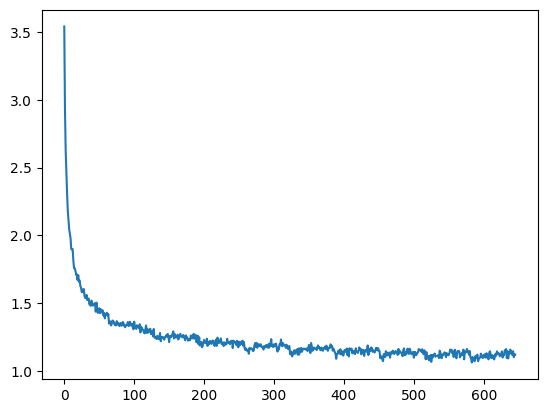

In [61]:
plt.plot(torch.tensor(l).view(-1, 10).mean(dim=-1))